In [1]:
import math, subprocess, time, random, os, shutil, sys
import pandas as pd
import numpy as np
from IPython.display import display, clear_output
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re

In [14]:
def run_program(test_file, method,n,k,v):
    #corre el programa con el metodo indicado en el test file indicado y devuelve el tiempo tomado en ejecutar
    #leemos la instancia
#     print(test_file)
    
#     print ([test_file, method, n, k , v])
    start = time.time() #comenzamos a medir el timepo
    
# filename 1 modo 2 l 3 k 4 vecinos 5 rand 6
    proc = subprocess.Popen(["../src/tp2","../python/"+test_file,method,str(n),str(k),str(v)],stdout = subprocess.PIPE, stderr=subprocess.PIPE, stdin=subprocess.PIPE, universal_newlines = True) #lanzamos proceso
    
    exit_code = proc.wait()#esperamos a que el proceso termien
#     print("fin.")
    end = time.time() #terminamos de medir el tiempo
    
    result = str(proc.stdout.read())
    #mandamos error de ser necesario 
    if exit_code != 0: raise RuntimeError(F"Hubo un error en la experimentacion para el algoritmo: {method} con la instancia {test_file}.")
    proc.stdin.close();
    proc.stdout.close();
    proc.stderr.close();
    
    result= result.rsplit("\n", 2)
#     print(result)
    result_n = result[0].split(' ', 2)[1]
#     print(result_n)
    result_first = int(result[1][0])
    return (end-start),result_n,result_first #devolvemos el timepo

In [3]:
def run_experiments(name = "exp", T=1):
    #recibe un nombre para darle al archivo de salida y lo que hace es correr todos los experimentos que se encuentren en la lista llamada experiments que debe ser generada con anterioridad
    columns = ["nombre","familia","exp_name", "method", "time","resultado","n","m","resultado_exp","first","dif","tabu","v","l","gap"]
    rows = []
    j = 1
#     T =1 # Numero de veces que se ejecuta cada experimento (para mayor fidelidad del tiempo).
    explen = str(len(experiments))
    
    
    for exp in tqdm(experiments, "Completed experiments"):
#         print(exp)
        times = []
#         respuestas = []
    
        for i in range(0, T):
            time,res,first= run_program(exp[5], exp[6],exp[7],exp[8],exp[9])
            times.append(time)
#             respuestas.append(res)
        
        rows.append([exp[0], exp[1],name, exp[6], np.mean(times),exp[4],exp[2],exp[3],int(res),first, int(res)-exp[4],exp[8],exp[9],exp[7],(int(res)-int(exp[4]))/int(exp[4])])
        j +=1
    result = pd.DataFrame(rows, columns=columns)
    
    if os.path.isfile("results/result.csv"):
        df = pd.read_csv("results/result.csv")
        df = df[df.exp_name != name]
        df = pd.concat([df, result], ignore_index = True, axis = 0)
    else:
        df = result
    
    
    df.to_csv("results/result.csv", index=False, header=True)

# Experimento velocidades y accuracy

In [93]:
experiments = [] #vaciamos lista para llenarla con los datos que queremos
l=1000
j=100
v=40
limite = 500
sin_limite = False
exp_name = "exp_vel"
familia = "pr" #ESTA FAMILIA ES UNA DE LAS TANTAS DE LA WEB QUE NOS DIERON
#primero observamos el indice
df_data = pd.read_csv("instancias"+"/indice.csv")
# df_data["path"] =  df_data["path"]
#Ahora filtramos la informacion para quedarnos con las instancias que queramos
df_data = df_data[(df_data["nombre"] == "bier127")|(df_data["nombre"] == "lin105") |(df_data["nombre"] == "ulysses22")|(df_data["nombre"] == "gr96")|(df_data["nombre"] == "dantzig42")]#para esto podemos usar la columna "familia"

#Ahora recorremos nuestro df con los exp a correr
for k in range(0, len(df_data)):
    row_k = df_data.iloc[k]
    if(sin_limite or int(re.search(r'\d+', row_k["nombre"])[0])< limite):
        
        experiments.append([row_k["nombre"],row_k["familia"], row_k["n"], row_k["m"], row_k["resultado"],row_k["path"],"hg",0,0,0,0])
        experiments.append([row_k["nombre"],row_k["familia"], row_k["n"], row_k["m"], row_k["resultado"],row_k["path"],"hagm",0,0,0,0])
        experiments.append([row_k["nombre"],row_k["familia"], row_k["n"], row_k["m"], row_k["resultado"],row_k["path"],"ts",l,j,v])
        experiments.append([row_k["nombre"],row_k["familia"], row_k["n"], row_k["m"], row_k["resultado"],row_k["path"],"bl",l,0,0,0])
    #llenamos el buffer de exps...1

run_experiments(exp_name)

Completed experiments:   0%|          | 0/20 [00:00<?, ?it/s]

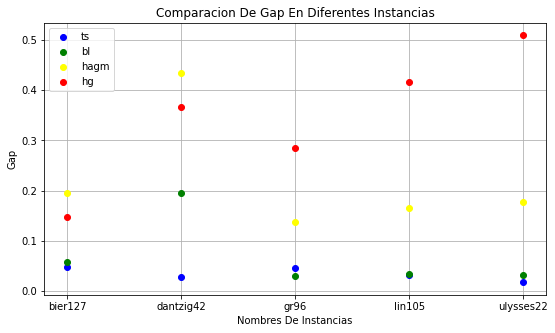

In [95]:
exp_name = "exp_vel"
df_resultados = pd.read_csv("results/result.csv")
df_resultados = df_resultados[(df_resultados["exp_name"]==exp_name)].sort_values(by=['nombre'])

title = "Comparacion de gap en diferentes instancias".title()
l = "o"
plt.figure(figsize=(9,5))

# plt.xlim(9,35)
# plt.ylim(21250,21600)

df_ts = df_resultados[(df_resultados["method"]=="ts")]

df_bl = df_resultados[(df_resultados["method"]=="bl")]

df_hagm = df_resultados[(df_resultados["method"]=="hagm")]

df_hg = df_resultados[(df_resultados["method"]=="hg")]

plt.plot()



plt.plot(df_ts["nombre"],df_ts["gap"],l, c="blue", label="ts")
plt.plot(df_bl["nombre"],df_bl["gap"],l, c="green", label="bl")
plt.plot(df_hagm["nombre"],df_hagm["gap"],l, c="yellow", label="hagm")
plt.plot(df_hg["nombre"],df_hg["gap"],l, c="red", label="hg")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.grid()


plt.title(title)
plt.xlabel('Nombres de instancias'.title()) 
plt.ylabel('Gap')  
plt.show()

# Experimentos de parametros

### Variando la cantidad de iteraciones (ts y bl)

In [23]:
experiments = [] 
j=100 #memo
v=40
sin_limite = True
exp_name = "exp_iter"
#primero observamos el indice
df_data = pd.read_csv("instancias/indice.csv")
#Ahora filtramos la informacion para quedarnos con las instancias que queramos
df_data = df_data[(df_data["nombre"] == "berlin52")|(df_data["nombre"] == "eil51") |(df_data["nombre"] == "att48")]#para esto podemos usar la columna "nombre
limite = 500
#Ahora recorremos nuestro df con los exp a correr
for k in range(0, len(df_data)):
    row_k = df_data.iloc[k]
    if(sin_limite or int(re.search(r'\d+', row_k["nombre"])[0])< limite):
        for l in range(1,1502,100):
            experiments.append([row_k["nombre"],row_k["familia"], row_k["n"], row_k["m"], row_k["resultado"],row_k["path"],"ts",l,j,v])
            experiments.append([row_k["nombre"],row_k["familia"], row_k["n"], row_k["m"], row_k["resultado"],row_k["path"],"bl",l,0,0,0])

run_experiments(exp_name)
df_data = pd.read_csv("results/result.csv")
display(df_data[df_data["exp_name"] == exp_name])

Completed experiments:   0%|          | 0/96 [00:00<?, ?it/s]

,nombre,familia,exp_name,method,time,resultado,n,m,resultado_exp,first,dif,tabu,v,l,gap
366,att48,att,exp_iter,ts,0.026685,10628,48,1176,12312,1,1684,100,40,1,0.158449
367,att48,att,exp_iter,bl,0.018562,10628,48,1176,11296,1,668,0,0,1,0.062853
368,att48,att,exp_iter,ts,0.305905,10628,48,1176,11058,1,430,100,40,101,0.040459
369,att48,att,exp_iter,bl,0.027948,10628,48,1176,10966,1,338,0,0,101,0.031803
370,att48,att,exp_iter,ts,0.662296,10628,48,1176,10979,1,351,100,40,201,0.033026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,eil51,eil,exp_iter,bl,0.121654,426,51,1326,450,1,24,0,0,1301,0.056338
458,eil51,eil,exp_iter,ts,5.941884,426,51,1326,429,1,3,100,40,1401,0.007042
459,eil51,eil,exp_iter,bl,0.139179,426,51,1326,450,1,24,0,0,1401,0.056338
460,eil51,eil,exp_iter,ts,6.516779,426,51,1326,429,1,3,100,40,1501,0.007042


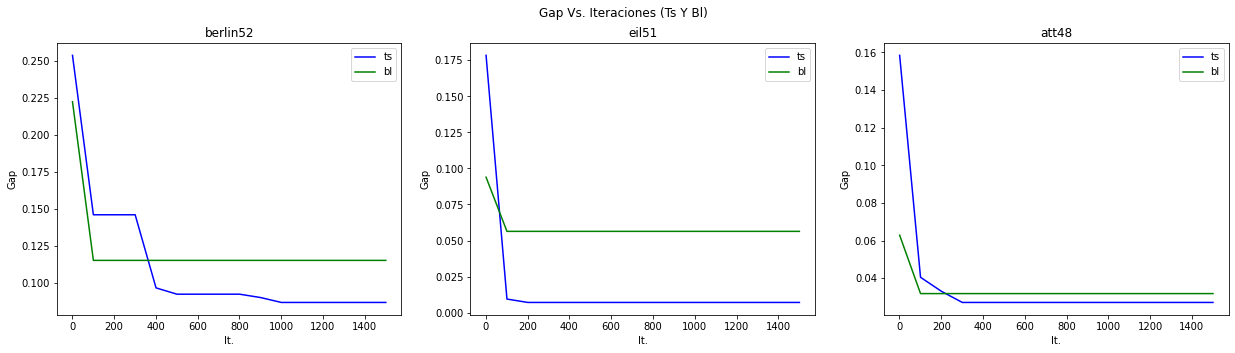

In [48]:
exp_name = "exp_iter"
df_resultados = pd.read_csv("results/result.csv")
df_resultados = df_resultados[(df_resultados["exp_name"]==exp_name)].sort_values(by=['l'])

title = "Gap VS. Iteraciones (ts y bl)"
l = "-"
name1 = "berlin52"
name2 = "eil51"
name3 = "att48"

df_ts = df_resultados[(df_resultados["method"]=="ts")]
df_bl = df_resultados[(df_resultados["method"]=="bl")]

df_ts1 = df_ts[df_ts["nombre"] == name1]
df_bl1 = df_bl[df_bl["nombre"] == name1]

df_ts2 = df_ts[df_ts["nombre"] == name2]
df_bl2 = df_bl[df_bl["nombre"] == name2]

df_ts3 = df_ts[df_ts["nombre"] == name3]
df_bl3 = df_bl[df_bl["nombre"] == name3]


fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(21,5))
fig.suptitle(title.title())

ax1.set_title(name1)
ax1.set_ylabel("Gap")
ax1.set_xlabel("It.")
ax2.set_title(name2)
ax2.set_ylabel("Gap")
ax2.set_xlabel("It.")
ax3.set_title(name3)
ax3.set_ylabel("Gap")
ax3.set_xlabel("It.")

ax1.plot(df_ts1["l"],df_ts1["gap"],l, c="blue", label="ts")
ax1.plot(df_bl1["l"],df_bl1["gap"],l, c="green", label="bl")


ax2.plot(df_ts2["l"],df_ts2["gap"],l, c="blue", label="ts")
ax2.plot(df_bl2["l"],df_bl2["gap"],l, c="green", label="bl")

ax3.plot(df_ts3["l"],df_ts3["gap"],l, c="blue", label="ts")
ax3.plot(df_bl3["l"],df_bl3["gap"],l, c="green", label="bl")
ax1.legend()
ax2.legend()
ax3.legend()

plt.show()

### Variando la cantidad de vecinos en ts

In [71]:
experiments = [] #vaciamos lista para llenarla con los datos que queremos
# n=1000 #iteraciones
j=100 #memo
v=1000
#vecinos
rand = 50
# limite = 
sin_limite = True
exp_name = "exp_vec"
# familia = "ch130" #ESTA FAMILIA ES UNA DE LAS TANTAS DE LA WEB QUE NOS DIERON
#primero observamos el indice
df_data = pd.read_csv("instancias/indice.csv")
#Ahora filtramos la informacion para quedarnos con las instancias que queramos
df_data = df_data[(df_data["nombre"] == "berlin52")|(df_data["nombre"] == "eil51") |(df_data["nombre"] == "att48")]

#Ahora recorremos nuestro df con los exp a correr
for k in range(0, len(df_data)):
    row_k = df_data.iloc[k]
    if(sin_limite or int(re.search(r'\d+', row_k["nombre"])[0])< limite):
        for v in [20,40,60,80,100]:
            for l in range(1,1502,100):
                experiments.append([row_k["nombre"],row_k["familia"], row_k["n"], row_k["m"], row_k["resultado"],row_k["path"],"ts",l,j,v,rand])


run_experiments(exp_name)
df_data = pd.read_csv("results/result.csv")
# df_data = df_data[df_data["exp_name"]== "ejemplo"]
display(df_data[df_data["exp_name"] == exp_name])

Completed experiments:   0%|          | 0/240 [00:00<?, ?it/s]

,nombre,familia,exp_name,method,time,resultado,n,m,resultado_exp,first,dif,tabu,v,l,gap
798,att48,att,exp_vec,ts,0.023601,10628,48,1176,12696,1,2068,100,20,1,0.194580
799,att48,att,exp_vec,ts,0.202511,10628,48,1176,11204,1,576,100,20,101,0.054196
800,att48,att,exp_vec,ts,0.388560,10628,48,1176,11139,1,511,100,20,201,0.048081
801,att48,att,exp_vec,ts,0.803725,10628,48,1176,11139,1,511,100,20,301,0.048081
802,att48,att,exp_vec,ts,0.963764,10628,48,1176,11139,1,511,100,20,401,0.048081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,eil51,eil,exp_vec,ts,8.266074,426,51,1326,437,1,11,100,100,1101,0.025822
1034,eil51,eil,exp_vec,ts,9.051351,426,51,1326,437,1,11,100,100,1201,0.025822
1035,eil51,eil,exp_vec,ts,9.817387,426,51,1326,437,1,11,100,100,1301,0.025822
1036,eil51,eil,exp_vec,ts,10.582179,426,51,1326,437,1,11,100,100,1401,0.025822


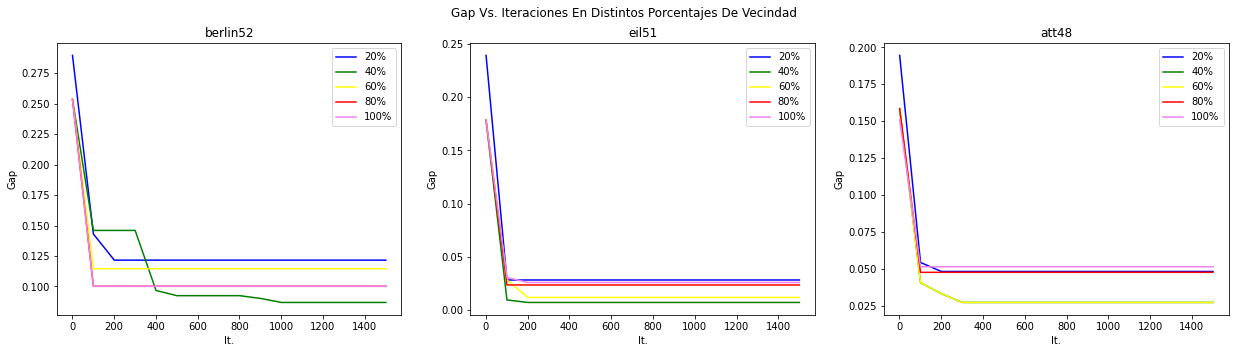

In [76]:
exp_name = "exp_vec"
df_resultados = pd.read_csv("results/result.csv")
df_resultados = df_resultados[(df_resultados["exp_name"]==exp_name)].sort_values(by=['l'])

title = "Gap VS. Iteraciones en distintos porcentajes de vecindad"
l = "-"
name1 = "berlin52"
name2 = "eil51"
name3 = "att48"

df_20 = df_resultados[(df_resultados["v"]==20)]
df_40 = df_resultados[(df_resultados["v"]==40)]
df_60 = df_resultados[(df_resultados["v"]==60)]
df_80 = df_resultados[(df_resultados["v"]==80)]
df_100 = df_resultados[(df_resultados["v"]==100)]


df_20_1 = df_20[(df_20["nombre"]==name1)]
df_40_1 = df_40[(df_40["nombre"]==name1)]
df_60_1 = df_60[(df_60["nombre"]==name1)]
df_80_1 = df_80[(df_80["nombre"]==name1)]
df_100_1 = df_100[(df_100["nombre"]==name1)]

df_20_2 = df_20[(df_20["nombre"]==name2)]
df_40_2 = df_40[(df_40["nombre"]==name2)]
df_60_2 = df_60[(df_60["nombre"]==name2)]
df_80_2 = df_80[(df_80["nombre"]==name2)]
df_100_2 = df_100[(df_100["nombre"]==name2)]

df_20_3 = df_20[(df_20["nombre"]==name3)]
df_40_3 = df_40[(df_40["nombre"]==name3)]
df_50_3 = df_60[(df_60["nombre"]==name3)]
df_80_3 = df_80[(df_80["nombre"]==name3)]
df_100_3 = df_100[(df_100["nombre"]==name3)]




fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(21,5))
fig.suptitle(title.title())

ax1.set_title(name1)
ax1.set_ylabel("Gap")
ax1.set_xlabel("It.")
ax2.set_title(name2)
ax2.set_ylabel("Gap")
ax2.set_xlabel("It.")
ax3.set_title(name3)
ax3.set_ylabel("Gap")
ax3.set_xlabel("It.")

ax1.plot(df_20_1["l"],df_20_1["gap"],l, c="blue", label="20%")
ax1.plot(df_40_1["l"],df_40_1["gap"],l, c="green", label="40%")
ax1.plot(df_60_1["l"],df_60_1["gap"],l, c="yellow", label="60%")
ax1.plot(df_80_1["l"],df_80_1["gap"],l, c="red", label="80%")
ax1.plot(df_100_1["l"],df_100_1["gap"],l, c="violet", label="100%")


ax2.plot(df_20_2["l"],df_20_2["gap"],l, c="blue", label="20%")
ax2.plot(df_40_2["l"],df_40_2["gap"],l, c="green", label="40%")
ax2.plot(df_60_2["l"],df_60_2["gap"],l, c="yellow", label="60%")
ax2.plot(df_80_2["l"],df_80_2["gap"],l, c="red", label="80%")
ax2.plot(df_100_2["l"],df_100_2["gap"],l, c="violet", label="100%")

ax3.plot(df_20_3["l"],df_20_3["gap"],l, c="blue", label="20%")
ax3.plot(df_40_3["l"],df_40_3["gap"],l, c="green", label="40%")
ax3.plot(df_60_3["l"],df_60_3["gap"],l, c="yellow", label="60%")
ax3.plot(df_80_3["l"],df_80_3["gap"],l, c="red", label="80%")
ax3.plot(df_100_3["l"],df_100_3["gap"],l, c="violet", label="100%")

ax1.legend()
ax2.legend()
ax3.legend()

plt.show()

### Variando tamano de la tabla tabu (ts)

In [57]:
experiments = [] #vaciamos lista para llenarla con los datos que queremos
# n=1000 #iteraciones
# j=50 #memo
v=40
sin_limite = True
exp_name = "exp_tabu"
# familia = "ch130" #ESTA FAMILIA ES UNA DE LAS TANTAS DE LA WEB QUE NOS DIERON
#primero observamos el indice
df_data = pd.read_csv("instancias/indice.csv")
#Ahora filtramos la informacion para quedarnos con las instancias que queramos
df_data = df_data[(df_data["nombre"] == "berlin52")|(df_data["nombre"] == "eil51") |(df_data["nombre"] == "att48")]

#Ahora recorremos nuestro df con los exp a correr
for k in range(0, len(df_data)):
    row_k = df_data.iloc[k]
    if(sin_limite or int(re.search(r'\d+', row_k["nombre"])[0])< limite):
        for j in [20,40,60,80,100,150,200]:
            for l in range(1,1502,100):
                experiments.append([row_k["nombre"],row_k["familia"], row_k["n"], row_k["m"], row_k["resultado"],row_k["path"],"ts",l,j,v,rand])


run_experiments(exp_name)
df_data = pd.read_csv("results/result.csv")
# df_data = df_data[df_data["exp_name"]== "ejemplo"]
display(df_data[df_data["exp_name"] == exp_name])

Completed experiments:   0%|          | 0/336 [00:00<?, ?it/s]

,nombre,familia,exp_name,method,time,resultado,n,m,resultado_exp,first,dif,tabu,v,l,gap
702,att48,att,exp_tabu,ts,0.021778,10628,48,1176,12312,1,1684,20,40,1,0.158449
703,att48,att,exp_tabu,ts,0.207397,10628,48,1176,11308,1,680,20,40,101,0.063982
704,att48,att,exp_tabu,ts,0.344759,10628,48,1176,11308,1,680,20,40,201,0.063982
705,att48,att,exp_tabu,ts,0.524510,10628,48,1176,11308,1,680,20,40,301,0.063982
706,att48,att,exp_tabu,ts,0.815564,10628,48,1176,11308,1,680,20,40,401,0.063982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,eil51,eil,exp_tabu,ts,7.735882,426,51,1326,429,1,3,200,40,1101,0.007042
1034,eil51,eil,exp_tabu,ts,8.191495,426,51,1326,429,1,3,200,40,1201,0.007042
1035,eil51,eil,exp_tabu,ts,9.001428,426,51,1326,429,1,3,200,40,1301,0.007042
1036,eil51,eil,exp_tabu,ts,9.819241,426,51,1326,429,1,3,200,40,1401,0.007042


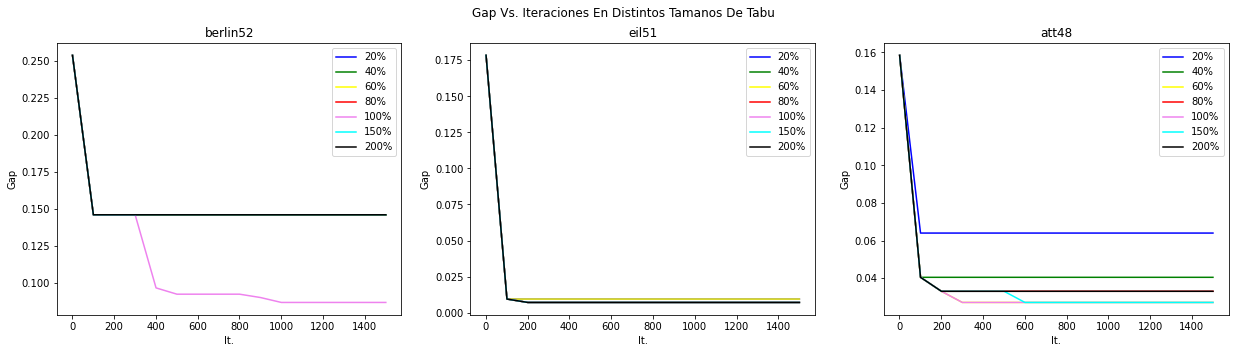

In [68]:
exp_name = "exp_tabu"
df_resultados = pd.read_csv("results/result.csv")
df_resultados = df_resultados[(df_resultados["exp_name"]==exp_name)].sort_values(by=['l'])

title =  "Gap VS. Iteraciones en distintos tamanos de tabu"
l = "-"
name1 = "berlin52"
name2 = "eil51"
name3 = "att48"



df_20 = df_resultados[(df_resultados["tabu"]==20)]
df_40 = df_resultados[(df_resultados["tabu"]==40)]
df_60 = df_resultados[(df_resultados["tabu"]==60)]
df_80 = df_resultados[(df_resultados["tabu"]==80)]
df_100 = df_resultados[(df_resultados["tabu"]==100)]
df_150 = df_resultados[(df_resultados["tabu"]==150)]
df_200 = df_resultados[(df_resultados["tabu"]==200)]


df_20_1 = df_20[(df_20["nombre"]==name1)]
df_40_1 = df_40[(df_40["nombre"]==name1)]
df_60_1 = df_60[(df_60["nombre"]==name1)]
df_80_1 = df_80[(df_80["nombre"]==name1)]
df_100_1 = df_100[(df_100["nombre"]==name1)]
df_150_1 = df_150[(df_150["nombre"]==name1)]
df_200_1 = df_200[(df_200["nombre"]==name1)]

df_20_2 = df_20[(df_20["nombre"]==name2)]
df_40_2 = df_40[(df_40["nombre"]==name2)]
df_60_2 = df_60[(df_60["nombre"]==name2)]
df_80_2 = df_80[(df_80["nombre"]==name2)]
df_100_2 = df_100[(df_100["nombre"]==name2)]
df_150_2 = df_150[(df_150["nombre"]==name2)]
df_200_2 = df_200[(df_200["nombre"]==name2)]

df_20_3 = df_20[(df_20["nombre"]==name3)]
df_40_3 = df_40[(df_40["nombre"]==name3)]
df_60_3 = df_60[(df_60["nombre"]==name3)]
df_80_3 = df_80[(df_80["nombre"]==name3)]
df_100_3 = df_100[(df_100["nombre"]==name3)]
df_150_3 = df_150[(df_150["nombre"]==name3)]
df_200_3 = df_200[(df_200["nombre"]==name3)]


fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(21,5))
fig.suptitle(title.title())

ax1.set_title(name1)
ax1.set_ylabel("Gap")
ax1.set_xlabel("It.")
ax2.set_title(name2)
ax2.set_ylabel("Gap")
ax2.set_xlabel("It.")
ax3.set_title(name3)
ax3.set_ylabel("Gap")
ax3.set_xlabel("It.")


ax1.plot(df_20_1["l"],df_20_1["gap"],l, c="blue", label="20%")
ax1.plot(df_40_1["l"],df_40_1["gap"],l, c="green", label="40%")
ax1.plot(df_60_1["l"],df_60_1["gap"],l, c="yellow", label="60%")
ax1.plot(df_80_1["l"],df_80_1["gap"],l, c="red", label="80%")
ax1.plot(df_100_1["l"],df_100_1["gap"],l, c="violet", label="100%")
ax1.plot(df_150_1["l"],df_150_1["gap"],l, c="cyan", label="150%")
ax1.plot(df_200_1["l"],df_200_1["gap"],l, c="black", label="200%")


ax2.plot(df_20_2["l"],df_20_2["gap"],l, c="blue", label="20%")
ax2.plot(df_40_2["l"],df_40_2["gap"],l, c="green", label="40%")
ax2.plot(df_60_2["l"],df_60_2["gap"],l, c="yellow", label="60%")
ax2.plot(df_80_2["l"],df_80_2["gap"],l, c="red", label="80%")
ax2.plot(df_100_2["l"],df_100_2["gap"],l, c="violet", label="100%")
ax2.plot(df_150_2["l"],df_150_2["gap"],l, c="cyan", label="150%")
ax2.plot(df_200_2["l"],df_200_2["gap"],l, c="black", label="200%")

ax3.plot(df_20_3["l"],df_20_3["gap"],l, c="blue", label="20%")
ax3.plot(df_40_3["l"],df_40_3["gap"],l, c="green", label="40%")
ax3.plot(df_60_3["l"],df_60_3["gap"],l, c="yellow", label="60%")
ax3.plot(df_80_3["l"],df_80_3["gap"],l, c="red", label="80%")
ax3.plot(df_100_3["l"],df_100_3["gap"],l, c="violet", label="100%")
ax3.plot(df_150_3["l"],df_150_3["gap"],l, c="cyan", label="150%")
ax3.plot(df_200_3["l"],df_200_3["gap"],l, c="black", label="200%")



ax1.legend()
ax2.legend()
ax3.legend()

plt.show()


# Experimentos con randoms

### Velocidad de todos los metodos para diferentes tamanos de isntancias randoms

In [96]:
experiments = [] #vaciamos lista para llenarla con los datos que queremos
l=1000
j=100
v=40
limite = 500
sin_limite = True
exp_name = "exp_rand_vel"
familia = "random" 
#primero observamos el indice
df_data = pd.read_csv("instancias"+"/indice.csv")
# df_data["path"] =  df_data["path"]
#Ahora filtramos la informacion para quedarnos con las instancias que queramos
df_data = df_data[df_data["familia"]==familia]#para esto podemos usar la columna "familia"

#Ahora recorremos nuestro df con los exp a correr
for k in range(0, len(df_data)):
    row_k = df_data.iloc[k]
    if(sin_limite or int(re.search(r'\d+', row_k["nombre"])[0])< limite):
        
        experiments.append([row_k["nombre"],row_k["familia"], row_k["n"], row_k["m"], row_k["resultado"],row_k["path"],"hg",0,0,0,0])
        experiments.append([row_k["nombre"],row_k["familia"], row_k["n"], row_k["m"], row_k["resultado"],row_k["path"],"hagm",0,0,0,0])
        experiments.append([row_k["nombre"],row_k["familia"], row_k["n"], row_k["m"], row_k["resultado"],row_k["path"],"ts",l,j,v])
        experiments.append([row_k["nombre"],row_k["familia"], row_k["n"], row_k["m"], row_k["resultado"],row_k["path"],"bl",l,0,0,0])
    #llenamos el buffer de exps...

run_experiments(exp_name,10)

Completed experiments:   0%|          | 0/364 [00:00<?, ?it/s]

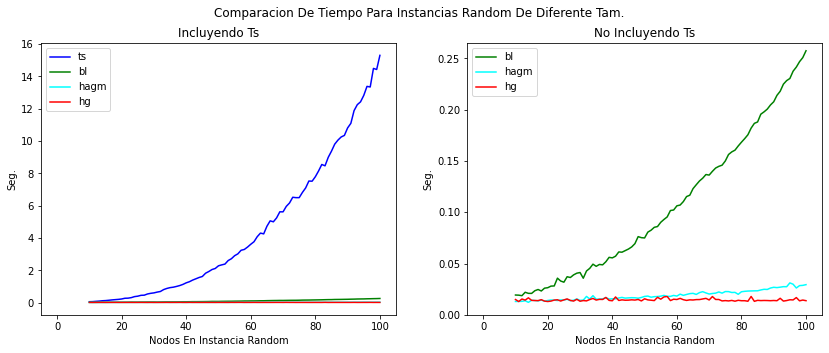

In [114]:
exp_name = "exp_rand_vel"
df_resultados = pd.read_csv("results/result.csv")
df_resultados = df_resultados[(df_resultados["exp_name"]==exp_name)].sort_values(by=['n'])

title = "Comparacion de tiempo para instancias random de diferente tam.".title()
l = True

# plt.xlim(9,35)
# plt.ylim(0,0.42)

df_ts = df_resultados[(df_resultados["method"]=="ts")]

df_bl = df_resultados[(df_resultados["method"]=="bl")]

df_hagm = df_resultados[(df_resultados["method"]=="hagm")]

df_hg = df_resultados[(df_resultados["method"]=="hg")]



fig,(ax1,ax2) = plt.subplots(1,2, figsize=(14,5))
fig.suptitle(title.title())
labely = "seg.".title()
labelx = "Nodos en Instancia Random".title()

name1 = "incluyendo ts".title()
name2 = "no incluyendo ts".title()
ax1.set_title(name1)
ax1.set_ylabel(labely)
ax1.set_xlabel(labelx)
ax2.set_title(name2)
ax2.set_ylabel(labely)
ax2.set_xlabel(labelx)


lines1 = ax1.plot(df_ts["n"],df_ts["time"],l, c="blue", label="ts")
lines2 = ax1.plot(df_bl["n"],df_bl["time"],l, c="green", label="bl")
lines3 = ax1.plot(df_hagm["n"],df_hagm["time"],l, c="cyan", label="hagm")
lines4 = ax1.plot(df_hg["n"],df_hg["time"],l, c="red", label="hg")

lines5 = ax2.plot(df_bl["n"],df_bl["time"],l, c="green", label="bl")
lines6 = ax2.plot(df_hagm["n"],df_hagm["time"],l, c="cyan", label="hagm")
lines7 = ax2.plot(df_hg["n"],df_hg["time"],l, c="red", label="hg")
ax2.set_ylim(0,0.265)
ax1.legend(handles=(lines1[0], lines2[0],lines3[0], lines4[0]), labels=("ts", "bl","hagm","hg"))
ax2.legend(handles=(lines5[0], lines6[0],lines7[0]), labels=("bl","hagm","hg"))
# ax2.legend(handles=[p1,p2], bbox_to_anchor=(0.75, 1), loc=2, borderaxespad=0.)


plt.show()

### Costo vs Tiempo en instancias random de tamano 50

In [98]:
experiments = [] #vaciamos lista para llenarla con los datos que queremos
l=1000
j=100
v=40
limite = 500
sin_limite = True
exp_name = "exp_rand_cost"
familia = "random-50" 
#primero observamos el indice
df_data = pd.read_csv("instancias"+"/indice.csv")
# df_data["path"] =  df_data["path"]
#Ahora filtramos la informacion para quedarnos con las instancias que queramos
df_data = df_data[df_data["familia"]==familia]#para esto podemos usar la columna "familia"

#Ahora recorremos nuestro df con los exp a correr
for k in range(0, len(df_data)):
    row_k = df_data.iloc[k]
    if(sin_limite or int(re.search(r'\d+', row_k["nombre"])[0])< limite):
        
        experiments.append([row_k["nombre"],row_k["familia"], row_k["n"], row_k["m"], row_k["resultado"],row_k["path"],"hg",0,0,0,0])
        experiments.append([row_k["nombre"],row_k["familia"], row_k["n"], row_k["m"], row_k["resultado"],row_k["path"],"hagm",0,0,0,0])
        experiments.append([row_k["nombre"],row_k["familia"], row_k["n"], row_k["m"], row_k["resultado"],row_k["path"],"ts",l,j,v])
        experiments.append([row_k["nombre"],row_k["familia"], row_k["n"], row_k["m"], row_k["resultado"],row_k["path"],"bl",l,0,0,0])
    #llenamos el buffer de exps...

run_experiments(exp_name)

Completed experiments:   0%|          | 0/80 [00:00<?, ?it/s]

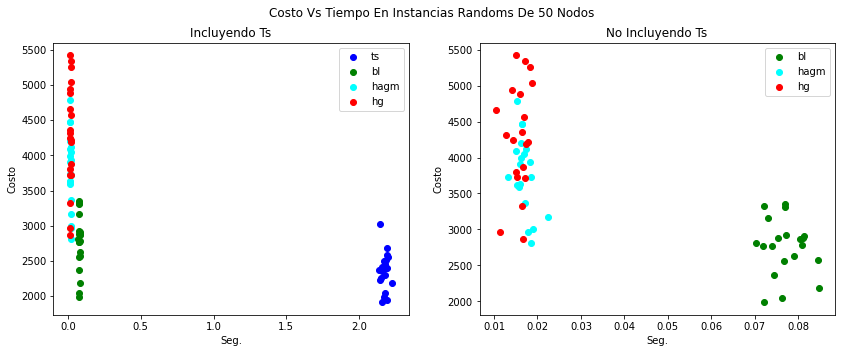

In [117]:
exp_name = "exp_rand_cost"
df_resultados = pd.read_csv("results/result.csv")
df_resultados = df_resultados[(df_resultados["exp_name"]==exp_name)].sort_values(by=['n'])

title = "Costo vs Tiempo en Instancias randoms de 50 nodos".title()
l = "o"

# plt.xlim(9,35)
# plt.ylim(0.98,1.01)



df_ts = df_resultados[(df_resultados["method"]=="ts")]

df_bl = df_resultados[(df_resultados["method"]=="bl")]

df_hagm = df_resultados[(df_resultados["method"]=="hagm")]

df_hg = df_resultados[(df_resultados["method"]=="hg")]



fig,(ax1,ax2) = plt.subplots(1,2, figsize=(14,5))
fig.suptitle(title.title())
labelx = "seg.".title()
labely = "costo".title()

name1 = "incluyendo ts".title()
name2 = "no incluyendo ts".title()
ax1.set_title(name1)
ax1.set_ylabel(labely)
ax1.set_xlabel(labelx)
ax2.set_title(name2)
ax2.set_ylabel(labely)
ax2.set_xlabel(labelx)


lines1 = ax1.plot(df_ts["time"],df_ts["resultado_exp"],l, c="blue", label="ts")
lines2 = ax1.plot(df_bl["time"],df_bl["resultado_exp"],l, c="green", label="bl")
lines3 = ax1.plot(df_hagm["time"],df_hagm["resultado_exp"],l, c="cyan", label="hagm")
lines4 = ax1.plot(df_hg["time"],df_hg["resultado_exp"],l, c="red", label="hg")

lines5 = ax2.plot(df_bl["time"],df_bl["resultado_exp"],l, c="green", label="bl")
lines6 = ax2.plot(df_hagm["time"],df_hagm["resultado_exp"],l, c="cyan", label="hagm")
lines7 = ax2.plot(df_hg["time"],df_hg["resultado_exp"],l, c="red", label="hg")
# ax2.set_ylim(0,0.265)
ax1.legend(handles=(lines1[0], lines2[0],lines3[0], lines4[0]), labels=("ts", "bl","hagm","hg"))
ax2.legend(handles=(lines5[0], lines6[0],lines7[0]), labels=("bl","hagm","hg"))


plt.show()